In [72]:
import importlib
import numpy as np
import sklearn
from matplotlib import pyplot as plt
from os.path import join
import os
import seaborn as sns
from torchvision.ops.misc import interpolate
from tqdm.notebook import tqdm as tqdm_notebook

#### Custum libraries
import lib.algos_maxRSA as max_rsa
import lib.utils_RSA as rsa
import lib.utils_CKA as cka
from lib.algos import *
from scipy.spatial import procrustes as scipro


importlib.reload(rsa)
importlib.reload(cka)
importlib.reload(max_rsa)

<module 'lib.algos_maxRSA' from '/home/alban/projects/SAYCam_Vs_EGO4D/lib/algos_maxRSA.py'>

In [2]:
dataset = 'ecoVal'
models  = ['ego', 'saycam', 'imagenet', 'supervised', 'random', 'resnet']
#models  = ['ego', 'saycam']
path2activations = f'/home/alban/Documents/activations_datadriven/%s_{dataset}/'

imagelists = {}
activations = {}
for model in models:
    with open(join(path2activations%model, 'imagepaths.txt'), 'r') as f:
        imagelists[model] = [line.strip() for line in f.readlines()]
    activations[model] = np.load(join(path2activations % model, 'cls_tokens.npy'))

activations[model].shape

(28250, 2048)

In [3]:
#### Normalize vectors
for model in models:
    norms = np.linalg.norm(activations[model], axis=1, keepdims=True)
    activations[model] = activations[model]/norms # normalization

In [4]:
### check if images were shown in the same order
assert imagelists['ego'] == imagelists['saycam']
imagelist = imagelists['ego'] # since they are the same, only consider one list

#### check if each category has the same number of images and list all categories in listcats
count = 0
cat = ''
listcat = list()
for i, imgp in enumerate(imagelist):
    current_cat = imgp.split('/')[-2]
    if i == 0:
        cat = current_cat
        listcat.append(current_cat)
    if cat != current_cat:
        cat = current_cat
        listcat.append(current_cat)
        count = 1
    else:
        count += 1

nb_per_cat = count # in val, 50 images per cate

nb_per_cat

50

In [5]:
### reshape activations according to include categories
cat_activations = activations.copy()

for model in models:
    shape = activations[model].shape
    cat_activations[model] = activations[model].reshape(-1, nb_per_cat, shape[-1])

In [40]:
compactness = {}
compact_categories = {}

for model in models:
    print(model)
    n_cats = len(cat_activations[model])
    centroids = np.array([np.mean(cat_act, axis=0) for cat_act in cat_activations[model]])

    # Compute metrics using generator expressions to save memory
    intra_vars = np.array([
        np.mean((cat_activations[model][i] - centroids[i]) ** 2)
        for i in range(n_cats)
    ])

    ### Distance between clusters
    inter_centroids = sklearn.metrics.euclidean_distances(centroids, squared=True)

    ### Nearest cluseter for each cluster
    nearest_cluster = list()
    for i in range(len(inter_centroids)):
        listidx = np.array(range(len(inter_centroids)))
        mask = listidx != i # exclude the diagonal
        nearest_cluster.append(np.argmin(inter_centroids[i][mask]))
    nearest_cluster = np.array(nearest_cluster)

    inter_vars = np.array([
        np.mean((cat_activations[model][nearest_cluster[i]] - centroids[i]) ** 2) for i in range(n_cats)
    ])

    compact = intra_vars/inter_vars

    # Sort and store results
    sort_indices = np.argsort(compact)
    compactness[model] = compact[sort_indices]
    compact_categories[model] = np.array(listcat)[sort_indices]

ego
saycam
imagenet
supervised
random
resnet


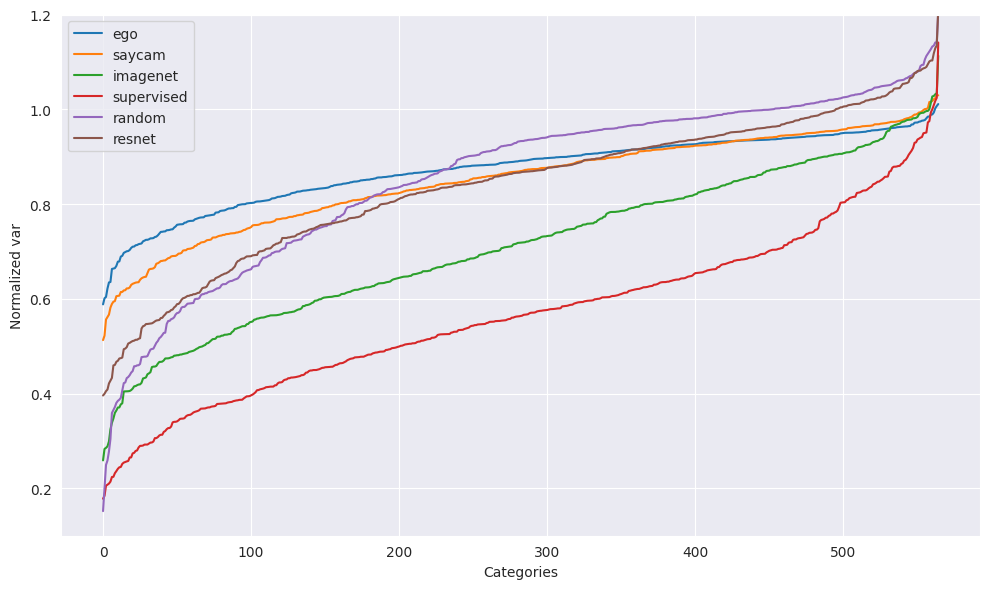

In [41]:
max_rsa.plot_stats_one(compactness,models,  ['Categories', 'Normalized var'])

In [78]:
nb_categories = len(listcat)
labels, sortedmaxdiffcats, maxdiffs = max_rsa.max_compactness_difference(
                compact_categories, compactness, nb_categories, listcat, models = ['saycam', 'ego'],
                nb_considered_categories = 10, compactness_diff_measure = 'rank'
            )

10
The 10 categories leading to the max differences between saycam and ego are ['0153_basket' '0236_cactus' '1844_mandolin' '1548_matchbook'
 '2186_cheetah' '0135_toilet' '2389_defibrillator' '1892_panda'
 '0466_lighthouse' '0163_lemon']
Category numbers are [ 52  90 467 423 501  43 524 474 169  57]
With differences in compactness of  [ 491.  449. -448. -405. -402.  392. -388. -388.  379.  376.]


In [79]:
max_dissimilarity_images = max_rsa.find_max_dissimilarity_images(
                cat_activations, ['saycam', 'ego'], labels[:10], nb_per_cat,
                images_per_subset=4, similarity_metric='pearson', diff = maxdiffs
            )

{'x': np.float32(1.1367345), 'y': np.float32(1.4914128), 'norm': np.float32(0.01639034)}


Processing categories:   0%|          | 0/10 [00:00<?, ?it/s]


Processing category: 52
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 52: [ 8 10 17 20]
Similarity: -0.7119

Processing category: 90
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 90: [ 0 18 22 30]
Similarity: -0.5935

Processing category: 467
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 467: [ 0 15 20 49]
Similarity: -0.7300

Processing category: 423
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 423: [ 7 37 47 49]
Similarity: -1.0868

Processing category: 501
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 501: [ 7  8 21 43]
Similarity: -0.6524

Processing category: 43
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 43: [13 25 33 35]
Similarity: -0.6448

Processing category: 524
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 524: [ 2  3 40 46]
Similarity: -0.5452

Processing category: 474
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 474: [ 5 24 30 37]
Similarity: -0.2608

Processing category: 169
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 169: [ 0 15 31 44]
Similarity: -0.2948

Processing category: 57
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 57: [ 3 12 22 38]
Similarity: -1.0958


{'x': np.float32(1.1367345), 'y': np.float32(1.4914128), 'norm': np.float32(0.01639034)}

Total selected images: 40
Extracting sub-RDMs...
RDM shapes: (40, 40), (40, 40)
Computing similarity between RDMs...

RDM similarity using 40 maximally dissimilar images: 0.386287


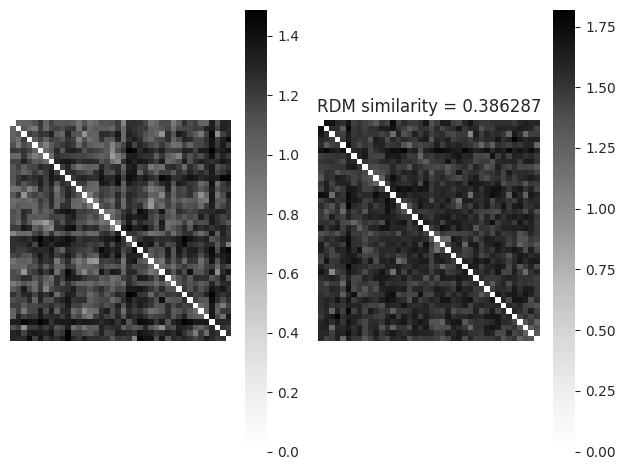

In [80]:
similarity_dict = max_rsa.compute_sub_rdm_similarity(
            max_dissimilarity_images, cat_activations, ['saycam', 'ego'], labels[:10])